# Initial Setups

## (Google Colab use only)

In [1]:
# Use Google Colab
use_colab = False

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')

    # cd to the appropriate working directory under my Google Drive
    %cd '/content/drive/My Drive/cs696ds_lexalytics/Prompting Experiments'
    
    # Install packages specified in requirements
    !pip install -r requirements.txt
    
    # List the directory contents
    !ls

## Experiment parameters

In [2]:
# We will use the following string ID to identify this particular (training) experiments
# in directory paths and other settings
experiment_id = 'prompt_lr_atsc_laptops_bert_base_multiple_prompts'

# Random seed
random_seed = 696

# path to pretrained MLM model folder or the string "bert-base-uncased"
lm_model_path = "bert-base-uncased"

# Proportion to be reserved for validation
validation_dataset_proportion = 0.2

# Prompts to be added to the end of each review text
sentiment_prompts = [
    "The {aspect} is [MASK].",
    "I [MASK] the {aspect}.",
    "I felt the {aspect} was [MASK].",
    "The {aspect} made me feel [MASK]."]

# Training settings
training_epochs = 10
training_batch_size = 32
training_learning_rate = 1e-3
training_weight_decay = 0.01

training_lm_freeze = False

validation_batch_size = 32
testing_batch_size = 32

## Package imports

In [3]:
import sys
import os
import random
import shutil
import copy
import inspect

import numpy as np
import torch
import transformers
import datasets
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tqdm

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import utils

# Random seed settings
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Print version information
print("Python version: " + sys.version)
print("NumPy version: " + np.__version__)
print("PyTorch version: " + torch.__version__)
print("Transformers version: " + transformers.__version__)

Python version: 3.8.2 (tags/v3.8.2:7b3ab59, Feb 25 2020, 23:03:10) [MSC v.1916 64 bit (AMD64)]
NumPy version: 1.18.4
PyTorch version: 1.7.1+cu110
Transformers version: 4.3.3


## PyTorch GPU settings

In [4]:
if torch.cuda.is_available():    
    torch_device = torch.device('cuda')

    # Set this to True to make your output immediately reproducible
    # Note: https://pytorch.org/docs/stable/notes/randomness.html
    torch.backends.cudnn.deterministic = False
    
    # Disable 'benchmark' mode: Set this False if you want to measure running times more fairly
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = True
    
    # Faster Host to GPU copies with page-locked memory
    use_pin_memory = True
    
    # Number of compute devices to be used for training
    training_device_count = torch.cuda.device_count()

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
    print("Number of CUDA devices: "+ str(training_device_count))
    
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False
    
    # Number of compute devices to be used for training
    training_device_count = 1

print()
print("PyTorch device selected:", torch_device)

CUDA Version: 11.0
cuDNN Version: 8004
CUDA Device Name: GeForce RTX 2060
CUDA Capabilities: (7, 5)
Number of CUDA devices: 1

PyTorch device selected: cuda


# Prepare Datasets for Prompt-based Classifier

## Load the SemEval dataset

In [5]:
# Load semeval for both domains
in_domain_semeval_dataset = datasets.load_dataset(
    os.path.abspath('../dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    data_files={
        'test': '../dataset_files/semeval_2014/Laptops_Test_Gold.xml',
        'train': '../dataset_files/semeval_2014/Laptop_Train_v2.xml',
    },
    cache_dir='../dataset_cache')

out_domain_semeval_dataset = datasets.load_dataset(
    os.path.abspath('../dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    data_files={
        'test': '../dataset_files/semeval_2014/Restaurants_Test_Gold.xml',
        'train': '../dataset_files/semeval_2014/Restaurants_Train_v2.xml',
    },
    cache_dir='../dataset_cache')

Using the latest cached version of the module from C:\Users\ibirl\.cache\huggingface\modules\datasets_modules\datasets\semeval2014_task4\f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969 (last modified on Mon Mar  8 17:14:36 2021) since it couldn't be found locally at C:\Users\ibirl\Documents\dsProjects\zero_shot_atsc\zero_shot_atsc\dataset_scripts\os.path.relpathsemeval2014_task4\semeval2014_task4.py\semeval2014_task4.py or remotely (FileNotFoundError).
Using custom data configuration default-9b6d847dca00ea02
Reusing dataset sem_eval2014_task4_dataset (dataset_cache\sem_eval2014_task4_dataset\default-9b6d847dca00ea02\0.0.1\f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969)
Using custom data configuration default-790c778f2f732468
Reusing dataset sem_eval2014_task4_dataset (dataset_cache\sem_eval2014_task4_dataset\default-790c778f2f732468\0.0.1\f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969)


In [6]:
out_domain_train = out_domain_semeval_dataset['train']
out_domain_test = out_domain_semeval_dataset['test']

in_domain_test = in_domain_semeval_dataset['test'] # Never use in-domain training data

## Train-validation split for out-domain SemEval data

In [7]:
# Training set size after validation split
new_out_domain_train_dataset_size = int(len(out_domain_train) * (1 - validation_dataset_proportion))
new_out_domain_valid_dataset_size = len(out_domain_train) - new_out_domain_train_dataset_size

print("Training dataset (out-domain) after split:", new_out_domain_train_dataset_size)
print("Validation dataset (out-domain) after split:", new_out_domain_valid_dataset_size)

Training dataset (out-domain) after split: 2881
Validation dataset (out-domain) after split: 721


In [8]:
out_domain_train = out_domain_train.shuffle(seed=random_seed)

new_out_domain_train_dataset = out_domain_train.select(
    indices=np.arange(new_out_domain_train_dataset_size))
new_out_domain_valid_dataset = out_domain_train.select(
    indices=np.arange(
        new_out_domain_train_dataset_size,
        new_out_domain_train_dataset_size + new_out_domain_valid_dataset_size))

Loading cached shuffled indices for dataset at dataset_cache\sem_eval2014_task4_dataset\default-790c778f2f732468\0.0.1\f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969\cache-6c63554de87b177c.arrow


In [9]:
print(new_out_domain_train_dataset[0])

{'aspect': 'Unda (Egg) rolls', 'sentiment': 0, 'text': 'I really recommend the very simple Unda (Egg) rolls.'}


# Zero-shot ATSC with Prompts + Logistic Regression Head

## Load the pretrained LM

In [10]:
# Load pretrained language model
lm = transformers.AutoModelForMaskedLM.from_pretrained(lm_model_path)
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased', cache_dir='../bert_base_cache')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Freeze the MLM main layer
if training_lm_freeze:
    for param in lm.parameters():
        param.requires_grad = False

## Define a new model with logistic regression head

In [11]:
classifier_model = utils.MultiPromptSentimentClassificationHead(
    lm=lm,
    num_class=3, num_prompts=len(sentiment_prompts), target_token_id=tokenizer.mask_token_id)

classifier_model = classifier_model.to(device=torch_device)

In [ ]:
if training_lm_freeze:
    # Recheck whether the MLM main layer is frozen
    for param in classifier_model.lm.bert.parameters():
        assert param.requires_grad == False

    # classifier_model.linear should be trainable
    for param in classifier_model.linear.parameters():
        assert param.requires_grad == True

## Training settings

In [12]:
train_dataloader = torch.utils.data.DataLoader(
    new_out_domain_train_dataset, batch_size=training_batch_size,
    pin_memory=use_pin_memory)

validation_dataloader = torch.utils.data.DataLoader(
    new_out_domain_valid_dataset, batch_size=validation_batch_size,
    pin_memory=use_pin_memory)

loss_function = torch.nn.CrossEntropyLoss()

optimizer = transformers.AdamW(
    classifier_model.parameters(),
    lr=training_learning_rate,
    weight_decay=training_weight_decay)

scheduler = transformers.get_constant_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0)

# The directory to save the best version of the head
trained_model_directory = os.path.join('..', 'trained_models', experiment_id)

shutil.rmtree(trained_model_directory, ignore_errors=True)
os.makedirs(trained_model_directory)

In [13]:
def compute_metrics(predictions, labels):
    preds = predictions.argmax(-1)

    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        y_true=labels, y_pred=preds, labels=[0,1,2], average='macro')

    acc = sklearn.metrics.accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Training loop

In [14]:
best_validation_loss = float('inf')
best_epoch = -1

for epoch in tqdm.notebook.tqdm(range(int(training_epochs))):

    print("Training epoch %d" % epoch)
    print()

    classifier_model.train()

    for batch in tqdm.notebook.tqdm(train_dataloader):

        reviews_repeated = []
        prompts_populated = []

        for prompt in sentiment_prompts:
            reviews_repeated = reviews_repeated + batch["text"]

            for aspect in batch["aspect"]:
                prompts_populated.append(prompt.format(aspect=aspect))

        batch_encoded = tokenizer(
            reviews_repeated, prompts_populated,
            padding='max_length', truncation='only_first', max_length=256,
            return_tensors='pt')
        
        batch_encoded = batch_encoded.to(torch_device)

        batch_label = batch["sentiment"]
        batch_label = batch_label.to(torch_device)

        optimizer.zero_grad()

        batch_output = classifier_model(batch_encoded)
        
        loss = loss_function(batch_output, batch_label)

        loss.backward()

        optimizer.step()
        scheduler.step()

    # Validate the model using val dataset
    with torch.no_grad():
        classifier_model.eval()

        print("Validation epoch %d" % epoch)
        print()

        predictions_val = torch.Tensor()
        labels_val = torch.Tensor()

        for batch_val in tqdm.notebook.tqdm(validation_dataloader):

            reviews_repeated = []
            prompts_populated = []

            for prompt in sentiment_prompts:
                reviews_repeated = reviews_repeated + batch_val["text"]

                for aspect in batch_val["aspect"]:
                    prompts_populated.append(prompt.format(aspect=aspect))

            batch_val_encoded = tokenizer(
                reviews_repeated, prompts_populated,
                padding='max_length', truncation='only_first', max_length=256,
                return_tensors='pt')

            batch_val_encoded.to(torch_device)

            batch_val_label = batch_val["sentiment"]

            batch_val_output = classifier_model(batch_val_encoded)

            batch_val_output = batch_val_output.to('cpu')

            predictions_val = torch.cat([predictions_val, batch_val_output])
            labels_val = torch.cat([labels_val, batch_val_label])

        # Compute metrics
        validation_loss = torch.nn.functional.cross_entropy(predictions_val, labels_val.long())
        validation_metrics = compute_metrics(predictions_val, labels_val)

        print(
            "Epoch {}, Training Loss: {}, Validation Loss: {}, Validation Metrics: {}".format(epoch, loss.item(), validation_loss.item(), validation_metrics))
        print()

        # Save the current epoch's model if the validation loss is lower than the best known so far
        if validation_loss.item() < best_validation_loss:

            if best_epoch != -1:
                try:
                    os.remove(os.path.join(trained_model_directory, 'epoch_{}.pt'.format(best_epoch)))
                except:
                    pass

            best_validation_loss = validation_loss.item()
            best_epoch = epoch

            torch.save(
                classifier_model.linear, os.path.join(trained_model_directory, 'epoch_{}.pt'.format(epoch)))

Training epoch 0




Validation epoch 0




Epoch 0, Training Loss: 1.1338070631027222, Validation Loss: 0.6762139797210693, Validation Metrics: {'accuracy': 0.7295423023578363, 'f1': 0.5110047846889952, 'precision': 0.660199373867194, 'recall': 0.5322686798296554}

Training epoch 1




Validation epoch 1




Epoch 1, Training Loss: 0.13269756734371185, Validation Loss: 0.6320180892944336, Validation Metrics: {'accuracy': 0.7364771151178918, 'f1': 0.563122438726567, 'precision': 0.6715094487571552, 'recall': 0.5654933701122726}

Training epoch 2




Validation epoch 2




Epoch 2, Training Loss: 0.4069490432739258, Validation Loss: 0.6389359831809998, Validation Metrics: {'accuracy': 0.7350901525658807, 'f1': 0.5494186911986828, 'precision': 0.7165212586412969, 'recall': 0.5460356174990322}

Training epoch 3




Validation epoch 3




Epoch 3, Training Loss: 0.3178020715713501, Validation Loss: 0.6161602735519409, Validation Metrics: {'accuracy': 0.7420249653259362, 'f1': 0.5627862543418013, 'precision': 0.7342729599800212, 'recall': 0.562069057297716}

Training epoch 4




Validation epoch 4




Epoch 4, Training Loss: 0.15960723161697388, Validation Loss: 0.5997893810272217, Validation Metrics: {'accuracy': 0.7420249653259362, 'f1': 0.5680358398503588, 'precision': 0.7146031426606966, 'recall': 0.5669913859852884}

Training epoch 5




Validation epoch 5




Epoch 5, Training Loss: 0.1871209591627121, Validation Loss: 0.5919889211654663, Validation Metrics: {'accuracy': 0.7558945908460472, 'f1': 0.6021427741539279, 'precision': 0.7399505256648115, 'recall': 0.5965749612853272}

Training epoch 6




Validation epoch 6




Epoch 6, Training Loss: 0.20439143478870392, Validation Loss: 0.57823646068573, Validation Metrics: {'accuracy': 0.7614424410540915, 'f1': 0.6394171582022533, 'precision': 0.7250360516945352, 'recall': 0.6221525358110723}

Training epoch 7




Validation epoch 7




Epoch 7, Training Loss: 0.16206391155719757, Validation Loss: 0.5710805058479309, Validation Metrics: {'accuracy': 0.7697642163661581, 'f1': 0.657104504632533, 'precision': 0.7175677756223303, 'recall': 0.6334756097560975}

Training epoch 8




Validation epoch 8




Epoch 8, Training Loss: 0.12506982684135437, Validation Loss: 0.5763898491859436, Validation Metrics: {'accuracy': 0.7656033287101248, 'f1': 0.6528925397176187, 'precision': 0.7098077434977116, 'recall': 0.6277845528455285}

Training epoch 9




Validation epoch 9




Epoch 9, Training Loss: 0.07657589763402939, Validation Loss: 0.57294762134552, Validation Metrics: {'accuracy': 0.7669902912621359, 'f1': 0.6724904311091925, 'precision': 0.6970433162532643, 'recall': 0.6590381823461092}




## Evaluation with in-domain test set



In [15]:
test_dataloader = torch.utils.data.DataLoader(
    in_domain_test, batch_size=testing_batch_size,
    pin_memory=use_pin_memory)

In [17]:
# Load the best found head weights
with torch.no_grad():
    classifier_model.linear = torch.load(
        os.path.join(trained_model_directory, 'epoch_{}.pt'.format(best_epoch)),
        map_location=torch_device)

    classifier_model.eval()

    predictions_test = torch.Tensor()
    labels_test = torch.Tensor()

    for batch_test in tqdm.notebook.tqdm(test_dataloader):

        reviews_repeated = []
        prompts_populated = []

        for prompt in sentiment_prompts:
            reviews_repeated = reviews_repeated + batch_test["text"]

            for aspect in batch_test["aspect"]:
                prompts_populated.append(prompt.format(aspect=aspect))

        batch_test_encoded = tokenizer(
            reviews_repeated, prompts_populated,
            padding='max_length', truncation='only_first', max_length=256,
            return_tensors='pt')

        batch_test_encoded.to(torch_device)

        batch_test_label = batch_test["sentiment"]

        batch_test_output = classifier_model(batch_test_encoded)

        batch_test_output = batch_test_output.to('cpu')

        predictions_test = torch.cat([predictions_test, batch_test_output])
        labels_test = torch.cat([labels_test, batch_test_label])

    # Compute metrics
    test_metrics = compute_metrics(predictions_test, labels_test)

    print(test_metrics)


{'accuracy': 0.6677115987460815, 'f1': 0.5302745386333622, 'precision': 0.6569910312986598, 'recall': 0.6089188223377119}


## Results visualization

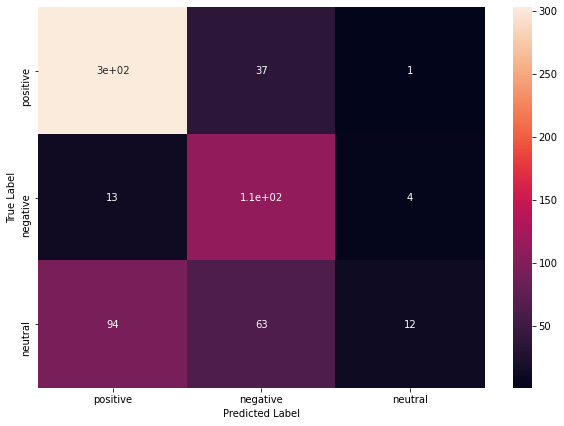

In [19]:
# Calculate metrics and confusion matrix based upon predictions and true labels
cm = sklearn.metrics.confusion_matrix(labels_test.detach().numpy(), predictions_test.detach().numpy().argmax(-1))

df_cm = pd.DataFrame(
    cm,
    index=[i for i in ["positive", "negative", "neutral"]],
    columns=[i for i in ["positive", "negative", "neutral"]])

plt.figure(figsize=(10, 7))

ax = sn.heatmap(df_cm, annot=True)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()